# Deconvolution for the simulated mouse embryo data

In [1]:
import stSCI
import scanpy as sc
import st_datasets as stds
from stSCI.utils.simulate import get_simulated_data
from stSCI.utils.plot import plot_deconvolution

## Data preprocessing

We generate simulated data using the `get_simulated_data` function. For data simulation, users must set the `distance` parameter to specify the radius for each simulated spot. By setting the `label_tag` parameter (`adata.obs[label_tag]`), our simulator can produce both the ground truth deconvolution (cell type proportion) matrix and the simulated spot labels, which represent the cell type of the highest proportion.

>>> INFO: Use local data.
>>> INFO: dataset name: Outside dataset, size: (5913, 25568), cluster: None.(0.869s)
>>> INFO: Generate simulated ST data, simulated data shape (646, 25568), average 6.546 cells in each spot. (0.67s).


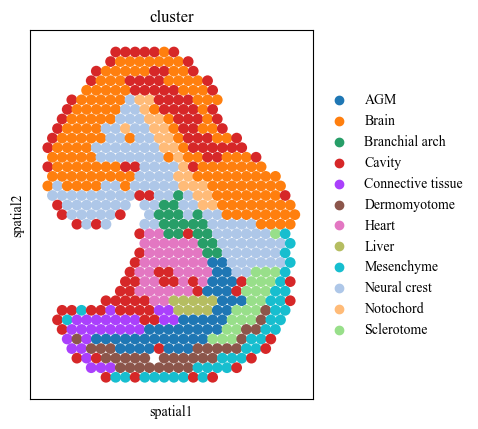

In [2]:
adata, _ = stds.get_data(
    stds.get_outside_data, 
    url='https://ftp.cngb.org/pub/SciRAID/stomics/STDS0000058/stomics/E9.5_E1S1.MOSTA.h5ad', 
    preprocess=False
)
sim_adata = get_simulated_data(adata, distance=3, label_tag='annotation')
sc.pl.spatial(sim_adata, color='cluster', spot_size=3.5)

In [3]:
sc_adata = adata.copy()
st_adata = sim_adata.copy()

sc.pp.normalize_total(sc_adata, target_sum=1e4)
sc.pp.normalize_total(st_adata, target_sum=1e4)
sc.pp.log1p(sc_adata)
sc.pp.log1p(st_adata)

## Model training

In [4]:
sc_adata, st_adata = stSCI.train(sc_adata, st_adata, cluster_key='annotation', deconvolution=True)

>>> INFO: Filtered 21 genes.
>>> INFO: Find 2979 same HVGs, result data shapes: [(5913, 2979), (646, 2979)].
>>> INFO: Generate 4522 edges, 6.000 edges per spot (0.00s).
>>> INFO: Finish PCA (0.40s).
>>> INFO: Finish centroid generation (0.45s).
>>> INFO: Finish centroid generation (0.01s).


>>> Train stSCI: 100%|██████████| 500/500 [00:27<00:00, 18.42it/s]


>>> INFO: Generate 30816 MNN pairs, 5.212 pairs per SC cell; 47.703 pairs per ST spot (0.02s).
>>> INFO: Finish generate deconvolution result (0.04s).
>>> INFO: Train stSCI model (30.75s).


## Evaluation

We provide the function `plot_deconvolution` to visualize the proportion for each cell.

>>> Predicted deconvolution result


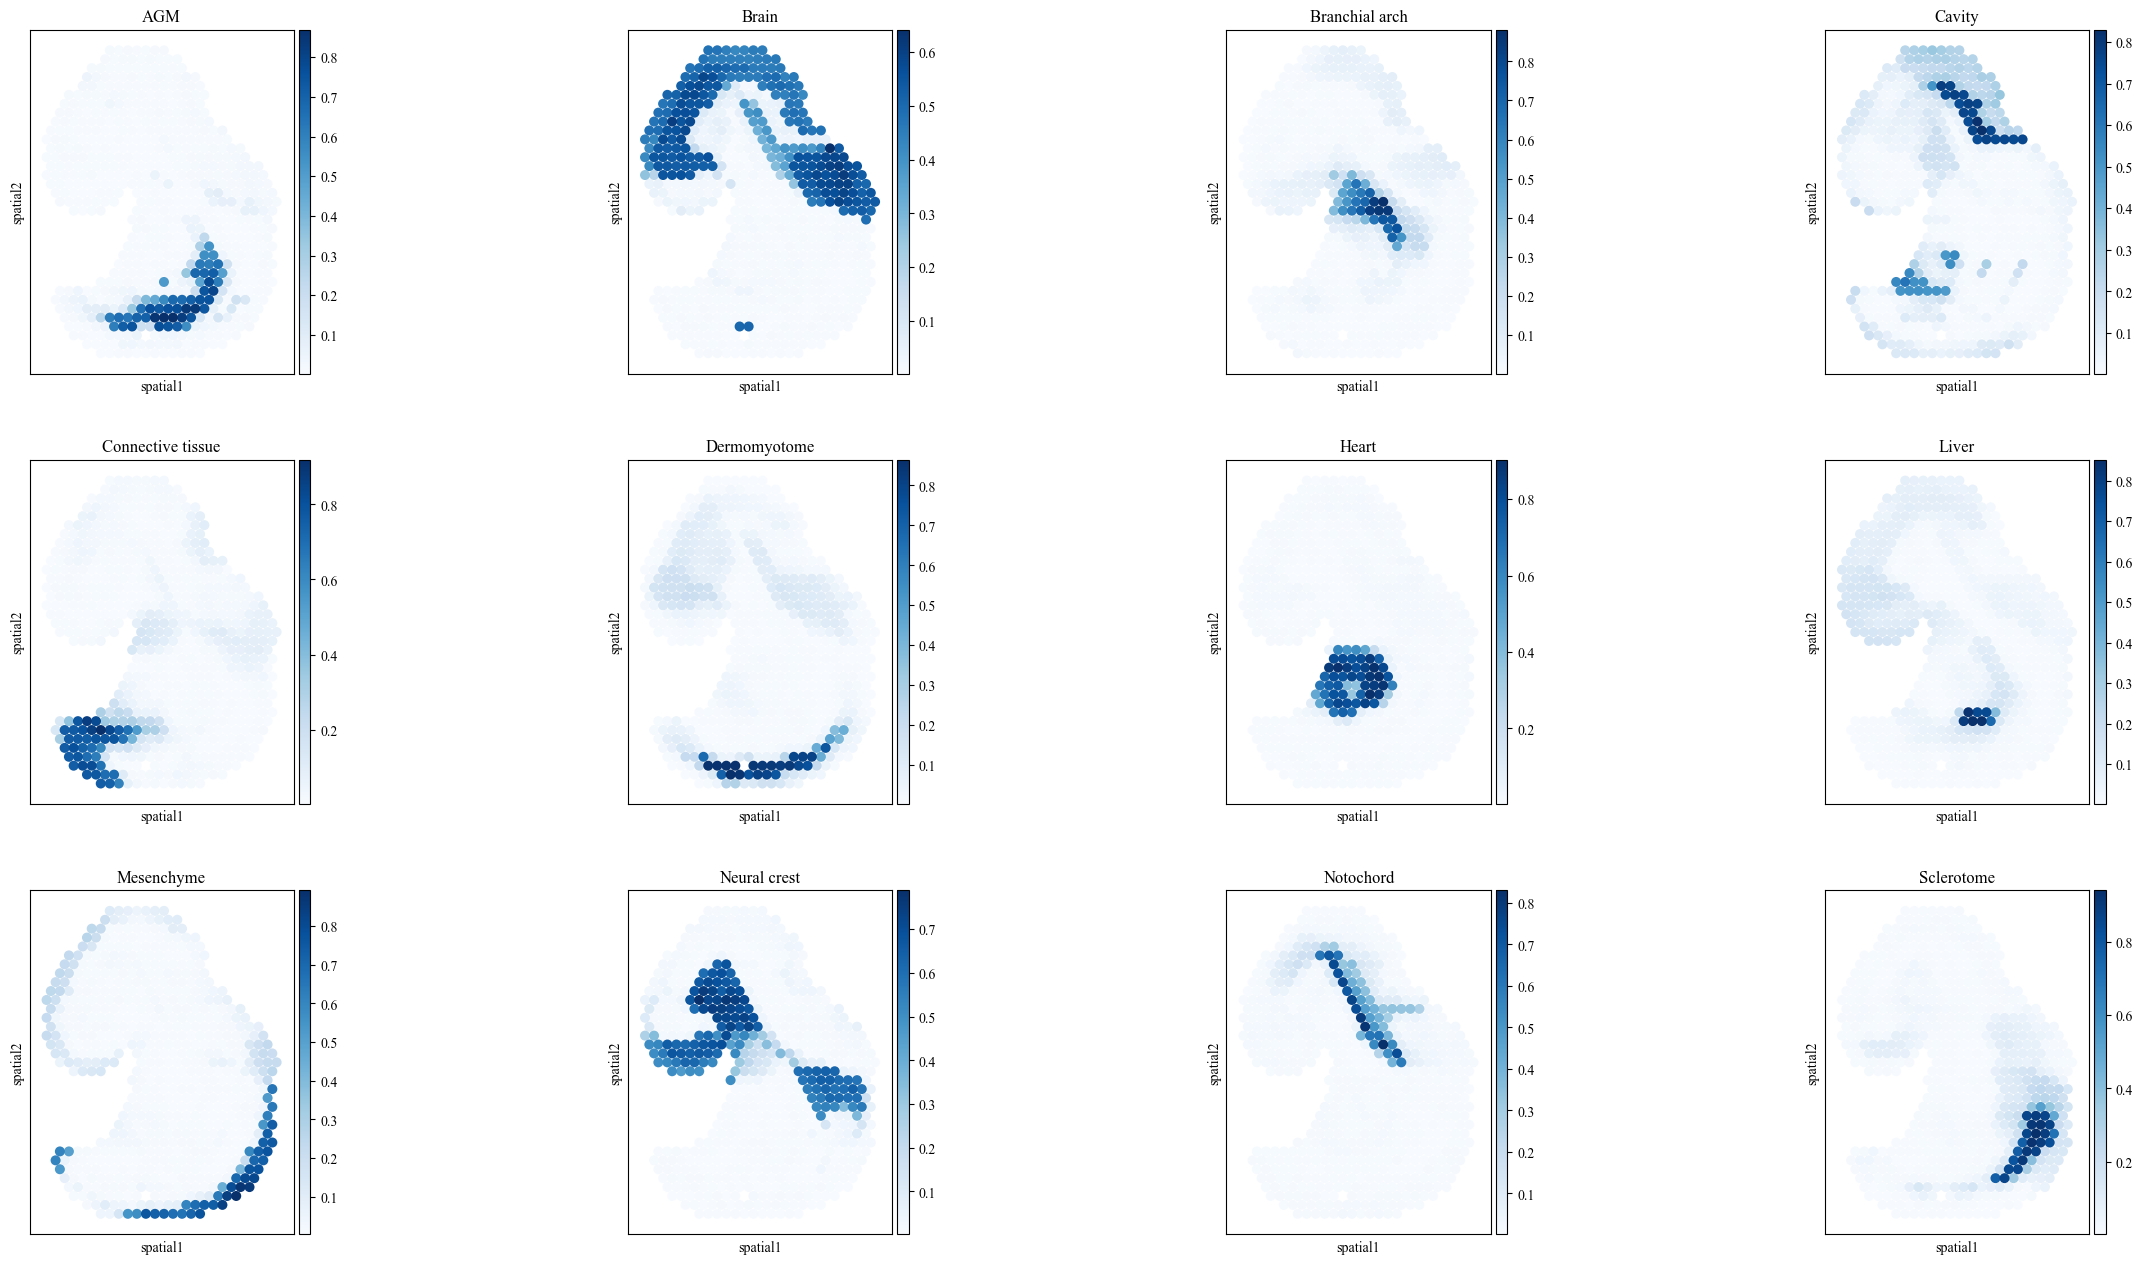

>>> Ground truth deconvolution result


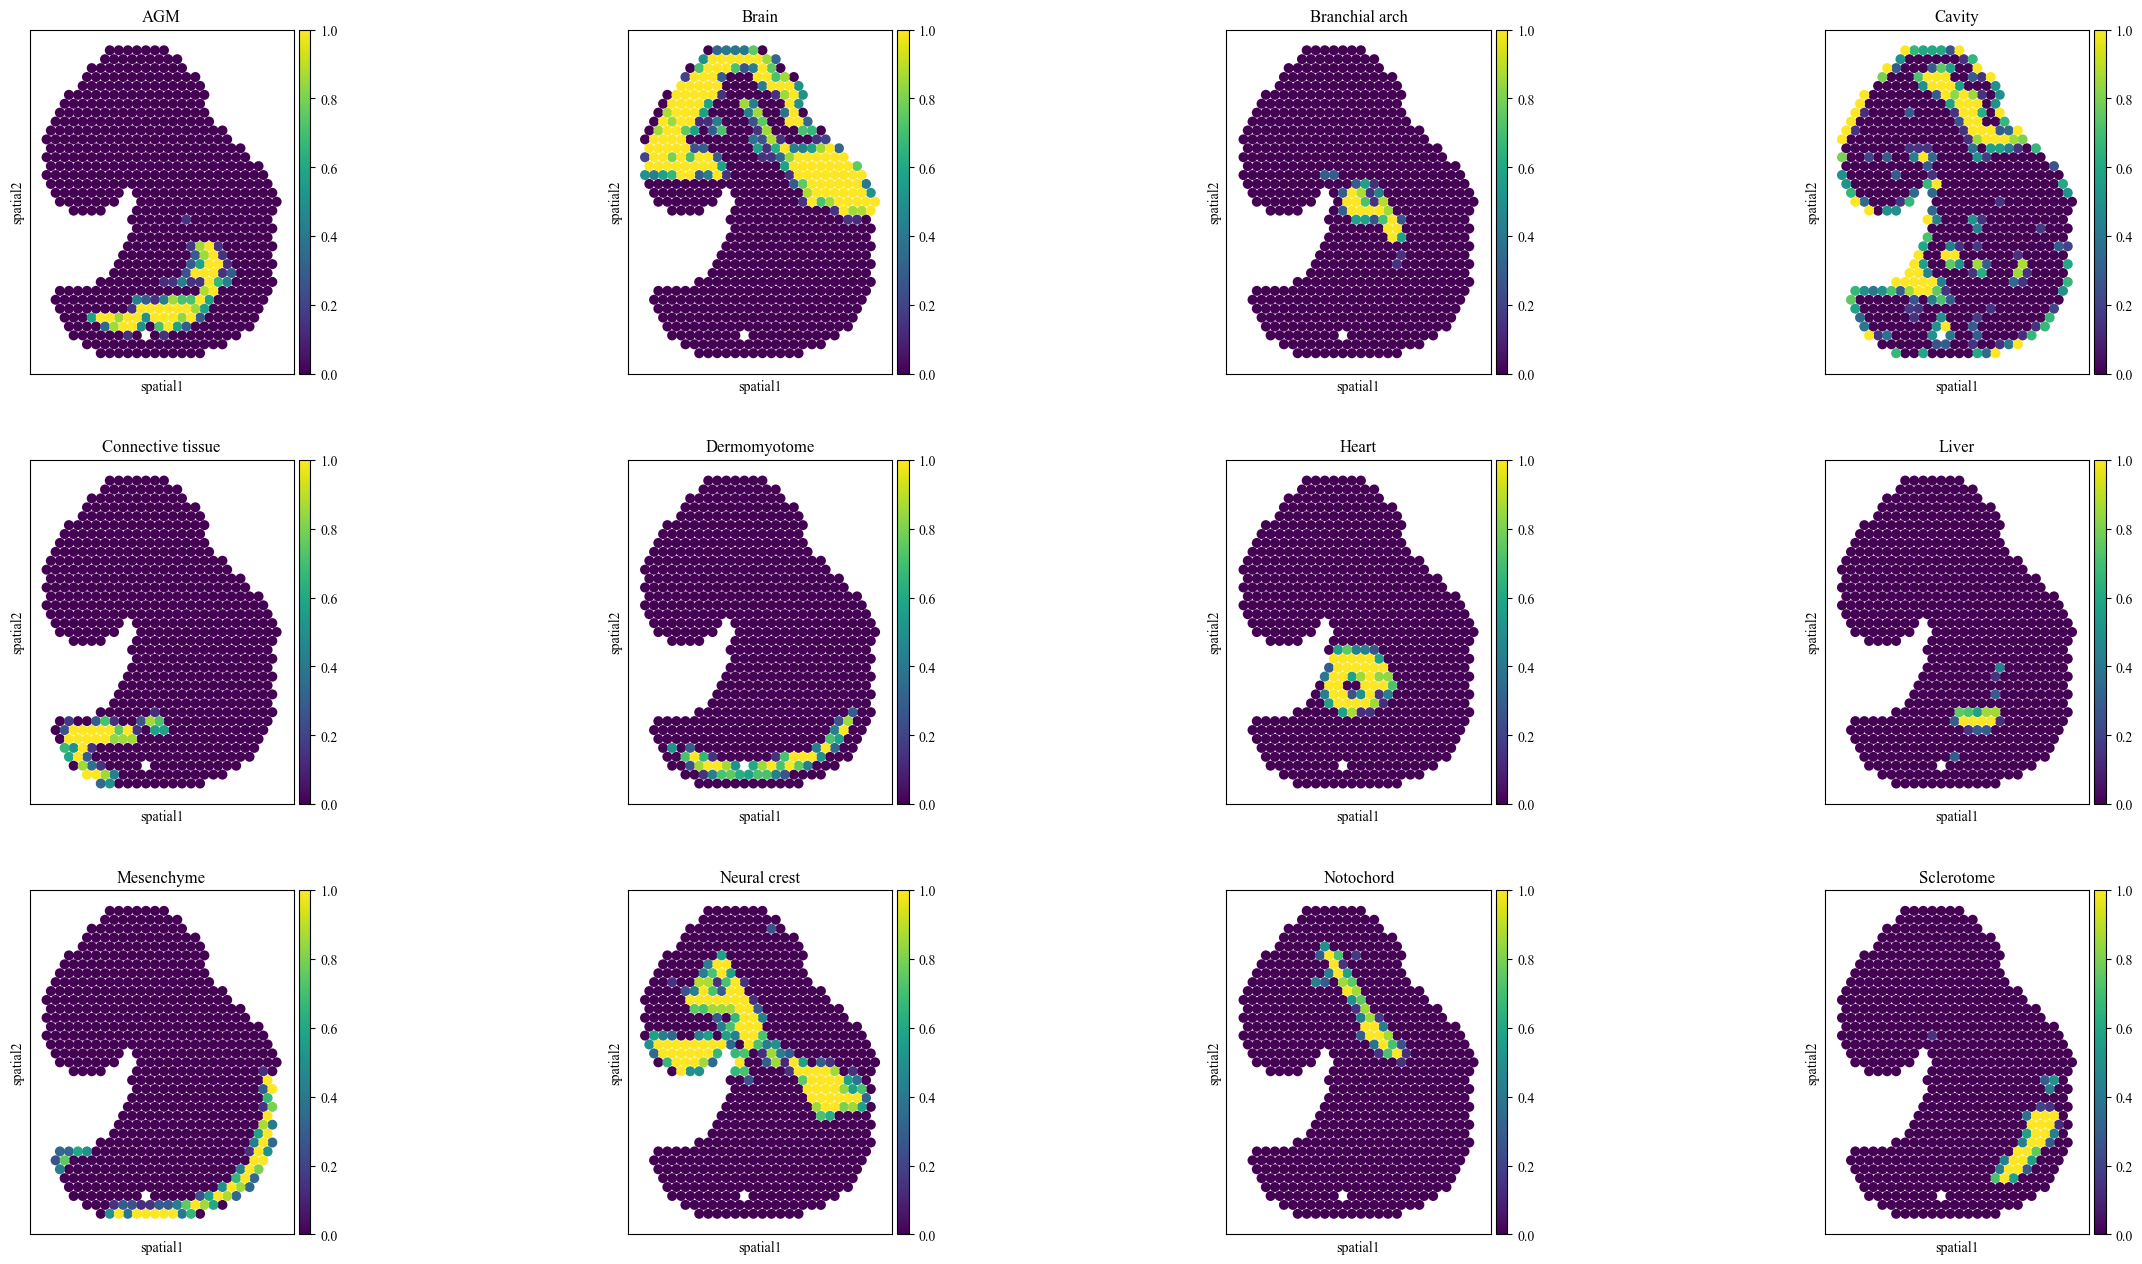

In [5]:
plot_deconvolution(st_adata, spot_size=3.5)

Moreover, user can use the `st_datasets` package to calculate the PCC and RMSE metric score.

In [6]:
pcc_score = stds.metrics.cal_PCC(st_adata.obsm['deconvolution_result'].to_numpy(),
    st_adata.obsm['decon_result'][st_adata.obsm['deconvolution_result'].columns].to_numpy())
rmse_score = stds.metrics.cal_RMSE(st_adata.obsm['deconvolution_result'].to_numpy(),
    st_adata.obsm['decon_result'][st_adata.obsm['deconvolution_result'].columns].to_numpy())
print(f'>>> PCC: {pcc_score:.3f}, 1/RMSE: {1/rmse_score:.3f}')

>>> PCC: 0.834, 1/RMSE: 7.113
